###### Content under Creative Commons Attribution license CC-BY 4.0, code under MIT license (c) 2015 Tingyu Wang, final project for Professor Lorena Barba's class: AeroPython.

#Ground Effect in Vortex Panel Method

### What is ground effect?

When you are talking with a pilot about landing on the airport runway, they will probably say they experience the feeling of floating above the ground under a certain attitude. For a well-trained pilot, this effect can make the landing more smooth. They keep a constant rate of descent before entering the ground-effect zone, then they adjust to a proper descent rate with ground effect in mind to achieve a very "soft" landing. However, for a novice, they might still fly very fast and do not have enough room to stop the aircraft on the runway, which might be quite dangerous. Or if you ever tried to drive a racecar, you will find that a racecar's chassis is much lower than a normal car. That ground effect is what makes the car attach to the ground and achieve a higher cornering speed.

In this notebook, we will exploit our knowledge about panel methods in potential flow to illustrate how ground effect changes the performance of a 2d airfoil. We will first develop a vortex panel method code with a linear vortex strength distribution. Then we add the "ground" to the system using 'the method of images' as we discussed in [lesson 07](http://nbviewer.ipython.org/urls/github.com/barbagroup/AeroPython/blob/master/lessons/07_Lesson07_methodOfImages.ipynb).

### Vortex Panel Method

In [1]:
import numpy
from matplotlib import pyplot, rcParams
from IPython.display import Image
%matplotlib inline
# customizing plot parameters
rcParams['figure.dpi'] = 100
rcParams['font.family'] = 'StixGeneral'
rcParams['font.size'] = 12

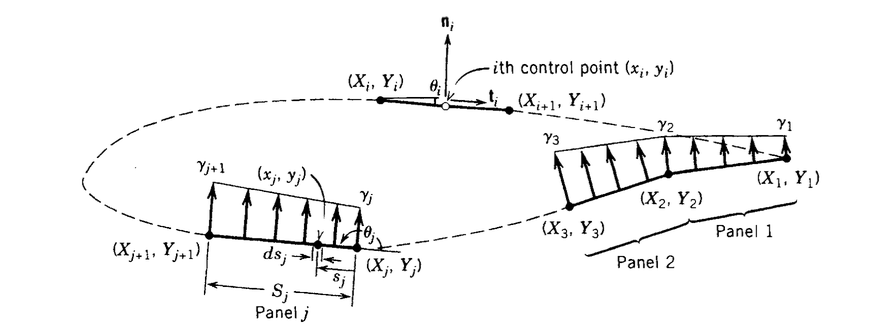

In [2]:
Image(filename='resources/panel.png')

image credit: Kuethe, Arnold M., and Chuen-Yen Chow. Foundations of Aerodynamics: Bases of Aerodynamics Design. Fifth Edition. Wiley, 1997, Page 156

Recall in [lesson 10](http://nbviewer.ipython.org/github/barbagroup/AeroPython/blob/master/lessons/10_Lesson10_sourcePanelMethod.ipynb), we use a source distribution to approximate the flow around an airfoil, and in [lesson 11](http://nbviewer.ipython.org/github/barbagroup/AeroPython/blob/master/lessons/11_Lesson11_vortexSourcePanelMethod.ipynb), we add a constant vortex strength on each panel to satisfy the Kutta condition at the trailing edge for a lift-generating airfoil. Actually there are lots of variations on the panel method, and we can use source, vortex or even doublet to represent the shape of the airfoil as long as the Kutta condition is satisfied at the trailing edge.

In this notebook, we assume there is a linearly varying vortex strength distribution along each panel as the figure shown above. For any panel $j$, the vortex strength $\gamma_j(s_j)$  can be determined by the vortex strength at its two end points $\gamma_j$ and $\gamma_{j+1}$. Thus for an $N$-panel airfoil, there are $N+1$ $\gamma$ s at the end points.

Let's introduce the Kutta condition for the vortex panel method: recall that Kutta condition ensures that the flow leaves tangentially at the trailing edge. So what will be the Kutta condition here? 

Simply:
$$
\gamma_1 + \gamma_{N+1} = 0
$$

To start with, let's first import the airfoil data from file.

In [3]:
x, y = numpy.loadtxt('resources/NACA0012_N=100', delimiter=' ', unpack=True)

-> If you want to use this code for other airfoils, you should write an input data file with x,y coordinates of each panel end points, from lower surface's trailing edge to upper surface's trailing edge.

Calculate the geometry parameters of panels.

In [4]:
xc = 0.5*(x[1:] + x[:-1])    # x of panel's center
yc = 0.5*(y[1:] + y[:-1])    # y of panel's center
np = len(xc)    # number of panels
l = numpy.sqrt((x[1:]-x[:-1])**2 + (y[1:]-y[:-1])**2)    # panel's length
theta = numpy.arctan2(y[1:]-y[:-1],x[1:]-x[:-1])    # panel's angle with horizontal axis

Now we have $N$ governing equations applied at the center of each panel that enforce $V_{n_{c_i}} = 0$, together with the Kutta condition. We have $N+1$ unknowns $(\gamma_1, \gamma_2 ... \gamma_{N+1})$. The rest of the work is to generate the other elements in the coefficient matrix $A$. 

$$
\begin{align*}
\phi\left(x_{c_i},y_{c_i}\right) &= V_\infty x_{c_i} \cos \alpha + V_\infty y_{c_i} \sin \alpha \\
&- \sum_{j=1}^N \int_j \frac{\gamma(s_j)}{2\pi} \tan^{-1} \left(\frac{y_{c_i}-y_j(s_j)}{x_{c_i}-x_j(s_j)}\right) {\rm d}s_j
\end{align*}
$$

where 
$$
\gamma(s_j) = \gamma_j + (\gamma_{j+1}-\gamma_j) \frac{s_j}{l_j}
$$

We know for a panel $i$, the Neumann boundary condition applies:
$$
\frac{\partial}{\partial n_i} \phi\left(x_{c_i},y_{c_i}\right) = 0
$$

we move the freestream term to RHS, which gives us:
$$\begin{align*}
& \quad \sum_{j=1}^N \frac{\gamma_j}{2\pi} \int_j \frac{\partial}{\partial n_i} \tan^{-1} \left(\frac{y_{c_i}-y_j(s_j)}{x_{c_i}-x_j(s_j)}\right) {\rm d}s_j \\
& - \sum_{j=1}^N \frac{\gamma_j}{2\pi} \int_j \frac{s_j}{l_j} \frac{\partial}{\partial n_i} \tan^{-1} \left(\frac{y_{c_i}-y_j(s_j)}{x_{c_i}-x_j(s_j)}\right) {\rm d}s_j \\
 & + \sum_{j=1}^N \frac{\gamma_{j+1}}{2\pi} \int_j \frac{s_j}{l_j} \frac{\partial}{\partial n_i} \tan^{-1} \left(\frac{y_{c_i}-y_j(s_j)}{x_{c_i}-x_j(s_j)}\right) {\rm d}s_j \\
&= V_{\infty}\sin(\theta_i - \alpha)
\end{align*}$$

In the previous lessons, we use ```scipy.integrate``` to solve for the integrals. Here we will use the analytical solution from *Kuethe's book: Foundations of Aerodynamics* to generate the coefficients.

Since the first two terms on LHS are related to $\gamma_j$, and the third one is for $\gamma_{j+1}$, we can combine the first two into one coefficient. In addition, we use a dimensionless circulation density $\gamma' = \frac{\gamma}{2\pi V_\infty}$. Now we rewrite the equation as:
$$
\sum_{j=1}^N \left( C_{n1}(i,j) \cdot \gamma'_j + C_{n2}(i,j) \cdot \gamma'_{j+1}\right) = \sin(\theta_i - \alpha)
$$

The two terms on the LHS represents the normal velocity at the $i$th control point induced by the vortex on the $j$th panel. $C_{n1}, C_{n2}$ are square matrices of size $N\times N$.

Kuethe's book gives the values of $C_{n1}, C_{n2}$ in Chapter 5.10 as below:

$$\begin{align*}
C_{n1}(i,j) &= 0.5DF + CG - C_{n2}(i,j) \\
C_{n2}(i,j) &= D + 0.5\frac{QF}{l_j} - (AC + DE) \frac{G}{l_j}
\end{align*}$$

when $i=j$:
$$C_{n1}(i,i) = -1 \quad C_{n2}(i,i) = 1$$ 

And all the following equations are also listed in the book from Page 157, 158:

$$\begin{align*}
A &= -\left(x_i - x_j\right)\cos \theta_j - \left(y_i-y_j\right) \sin\theta_j \\
B &= \left(x_i - x_j\right)^2 + \left(y_i-y_j\right)^2 \\
C &= \sin \left(\theta_i - \theta_j \right) \\
D &= \cos \left(\theta_i - \theta_j \right) \\
E &= \left(x_i - x_j\right)\sin\theta_j - \left(y_i - y_j\right)\cos\theta_j\\
F &= ln \left( 1 + \frac{l_j^2 + 2Al_j}{B} \right) \\
G &= \tan^{-1} \left( \frac{El_j}{B+Al_j} \right) \\
P &= \left(x_i - x_j\right)\sin \left( \theta_i- 2\theta_j\right) + \left(y_i-y_j\right) \cos\left( \theta_i- 2\theta_j\right) \\
Q &= \left(x_i - x_j\right)\cos \left( \theta_i- 2\theta_j\right) + \left(y_i-y_j\right) \sin\left( \theta_i- 2\theta_j\right) \\
\end{align*}$$

To derive all the coefficients above, we need the analytical solutions of those two integrals, and they can be found on equation (10.34~10.40) and (10.68~10.73) in the book: *Low Speed Aerodynamics by Katz & Plotkin*.

For the tangential velocity at the control point on the $i$th panel, we can use $\frac{\partial}{\partial t_i} \phi\left(x_{c_i},y_{c_i}\right)$ to solve that:

$$
V_{t_i} = \cos \left( \theta_i - \alpha \right) + \sum_{j=1}^N \left( C_{t1}(i,j) \cdot \gamma'_j + C_{t2}(i,j) \cdot \gamma'_{j+1}\right) 
$$

where
$$\begin{align*}
C_{t1}(i,j) &= 0.5CF - DG - C_{t2}(i,j) \\
C_{t2}(i,j) &= C + 0.5\frac{PF}{l_j} - (AD - CE) \frac{G}{l_j}
\end{align*}$$

when $i=j$:
$$C_{t1}(i,i) = \pi/2 \quad C_{t2}(i,i) = \pi/2$$ 

Given the panel's information and the analytical solution shown above, we can create a function to evaluate these four square matrices.

In [5]:
def evaluate_coefficient(x, y, xc, yc, theta, l):
    """Given the end points' coordinates (x,y), angles(theta), panel length (l) of target panels, evaluate their contributions to source panels with control points (xc, yc), and return the panel-panel coefficient matrix in normal and tangential direction, and for the left end and right end respectively.
    
    Parameters:
    ----------
    x, y: (array of float)
          x,y coordinates of panels' end points
    xc, yc: (array of float)
            x,y coordinates of control points on panels
    theta: (array of float)
            array of angles between x-axis and panels
    l: (array of float)
        array of panels' length
        
    Returns:
    -------
    cn1: (array of float)
         the source panel's left end vortex's contribution on target panel in normal direction
    cn2: (array of float)
         the source panel's right end vortex's contribution on target panel in normal direction     
    ct1: (array of float)
         the source panel's left end vortex's contribution on target panel in tangential direction
    ct2: (array of float)
         the source panel's right end vortex's contribution on target panel in tangential direction
    """
    # initialize the coefficient matrix
    np = len(xc)
    cn1 = numpy.zeros((np,np), dtype=float)
    cn2 = numpy.zeros((np,np), dtype=float)
    ct1 = numpy.zeros((np,np), dtype=float)
    ct2 = numpy.zeros((np,np), dtype=float)
    # fill in the matrix when i=j (singularity)
    numpy.fill_diagonal(cn1, -1.)
    numpy.fill_diagonal(cn2, 1.)
    numpy.fill_diagonal(ct1, numpy.pi/2)
    numpy.fill_diagonal(ct2, numpy.pi/2)
    # double loop in i,j to evaluate j's contribution to i's panel when i!=j
    for i in range(np):
        for j in range(i)+range(i+1,np):
            A = -(xc[i]-x[j])*numpy.cos(theta[j])-(yc[i]-y[j])*numpy.sin(theta[j])
            B = (xc[i]-x[j])**2+(yc[i]-y[j])**2
            C = numpy.sin(theta[i]-theta[j])
            D = numpy.cos(theta[i]-theta[j])
            E = (xc[i]-x[j])*numpy.sin(theta[j])-(yc[i]-y[j])*numpy.cos(theta[j])
            F = numpy.log(1+(l[j]**2+2*A*l[j])/B)
            G = numpy.arctan2((E*l[j]),(B+A*l[j]))
            P = (xc[i]-x[j])*numpy.sin(theta[i]-2*theta[j])+(yc[i]-y[j])*numpy.cos(theta[i]-2*theta[j])
            Q = (xc[i]-x[j])*numpy.cos(theta[i]-2*theta[j])-(yc[i]-y[j])*numpy.sin(theta[i]-2*theta[j])
            cn2[i,j]=D+0.5*Q*F/l[j]-(A*C+D*E)*G/l[j]
            cn1[i,j]=0.5*D*F+C*G-cn2[i,j]
            ct2[i,j]=C+0.5*P*F/l[j]+(A*D-C*E)*G/l[j]
            ct1[i,j]=0.5*C*F-D*G-ct2[i,j]
    return cn1, cn2, ct1, ct2      

In [6]:
cn1, cn2, ct1, ct2 = evaluate_coefficient(x, y, xc, yc, theta, l)

For each control point, we know that:

$$
\sum_{j=1}^N \left( C_{n1}(i,j) \cdot \gamma'_j + C_{n2}(i,j) \cdot \gamma'_{j+1}\right) = \sin(\theta_i - \alpha)
$$

now we can build the linear system as:

$$
\sum_{j=1}^{N+1} A_n(i,j) \cdot \gamma'_j = \sin(\theta_i - \alpha)
$$
we should notice that $j$ index here denotes the $\gamma$ rather than the panel index. Hence, the first column of matrix $A_n$ has only the contribution from the start point vortex of the first panel $C_{n1}(i,1)$, while the last column of $A_n$ has only the contribution from the end point vortex of the last panel $C_{n2}(i,2)$. Other columns in between consist of two parts: the $j$th panel's start point's influence $C_{n1}(i,j)$ and the $j-1$th panel's end point's influence $C_{n2}(i,j-1)$. Finally, we append the Kutta condition at the last row. And we use the same procedure to construct the $A_t$, except for the Kutta condition.

In [7]:
def build_A(cn1, cn2, ct1, ct2):
    """Build the coefficient matrix of the linear system based on the panel-panel coefficient matrix
    
    Parameters:
    ----------
    cn1, cn2, ct1, ct2: see docstring in function 'evaluate_coefficient'
    
    Returns:
    -------
    an: (array of float)
        the coefficient matrix in normal direction, including the kutta-condition in the last row
    at: (array of float)
        the coefficient matrix in tangential direction
    """
    # initialize the coefficient matrix for normal and tangential directions
    np = cn1.shape[0]
    an = numpy.zeros((np+1,np+1),dtype=float)
    at = numpy.zeros((np,np+1),dtype=float)
    # loop in every element in the coefficient matrix
    for i in range(np):
        # fill the first column (0th-panel's first end's effect on ith-panel)
        # and the last column (-1th-panel's second end's effect on ith-panel)
        an[i,0] = cn1[i,0]
        an[i,-1] = cn2[i,-1]
        at[i,0] = ct1[i,0]
        at[i,-1] = ct2[i,-1]
        # each element in the middle are influenced by two panels
        # j-th panel's first end and (j-1)th panel's right end
        for j in range(1,np):
            an[i,j] = cn1[i,j] + cn2[i,j-1]
            at[i,j] = ct1[i,j] + ct2[i,j-1]
    # kutta condition
    an[-1,0] = 1.
    an[-1,-1] = 1.
    return an, at

In [8]:
an, at = build_A(cn1, cn2, ct1, ct2)

Define the freestream condition, and calculate the RHS array (Be careful that we already use a dimensionless $\gamma$).

In [9]:
alpha = 10.0    # aoa in degrees
b = numpy.sin(theta-alpha/180.*numpy.pi)    # freestream's contribution
b = numpy.append(b, 0.)    # add kutta condition

Solve the linear system of equations in the normal direction.

In [10]:
gamma = numpy.linalg.solve(an, b)

Evaluate the tangential velocity and pressure coefficient at control points.

In [11]:
vt = numpy.dot(at, gamma) + numpy.cos(theta-alpha/180.*numpy.pi)
cp = 1 - vt**2

Now we can wrap our code in one function for convenience.

In [12]:
def vortex_panel_method(filename, alpha):
    """Given the filename of panel coordinates file, and the angle of attack, return the control points, its pressure coefficient and total lift.
    
    Parameters:
    ----------
    filename: (string)
              Panel's coordinates input file
    alpha: (float)
            angle of attack in degree
    
    Returns:
    -------
    xc: (array of float)
        array of control points' x coordinates
    cp: (array of float)
        array of pressure coefficient at the control points
    cl: (float)
        the lift coefficient of the airfoil
           
    """
    # load airfoil data
    x, y = numpy.loadtxt('resources/'+filename, delimiter=' ', unpack=True)
    
    # calculate the geometry parameters of panels
    xc = 0.5*(x[1:] + x[:-1])    # x of panel's center
    yc = 0.5*(y[1:] + y[:-1])    # y of panel's center
    np = len(xc)    # number of panels
    l = numpy.sqrt((x[1:]-x[:-1])**2 + (y[1:]-y[:-1])**2)    # panel's length
    theta = numpy.arctan2(y[1:]-y[:-1],x[1:]-x[:-1])    # panel's angle with horizontal axis
    
    # evaluate the panel-to-panel coefficient 
    cn1, cn2, ct1, ct2 = evaluate_coefficient(x, y, xc, yc, theta, l)
    
    # evaluate the coefficient matrix A (related to gammas)
    an, at = build_A(cn1, cn2, ct1, ct2)
    
    # calculate the rhs
    b = numpy.sin(theta-alpha/180.*numpy.pi)    # freestream's contribution
    b = numpy.append(b, 0.)    # add kutta condition
    
    # solve the linear system
    gamma = numpy.linalg.solve(an, b)
    
    # evaluate the tangential velocity and pressure coefficient at control points
    vt = numpy.dot(at, gamma) + numpy.cos(theta-alpha/180.*numpy.pi)
    cp = 1 - vt**2
    
    # evaluate the lift
    cl = -numpy.dot(cp, l*numpy.cos(theta-alpha/180.*numpy.pi))
    
    return xc, cp, cl

### Verification using NACA 0012

Before we use the code in ground effect, we should always show that it is correct. In order to verify, we test NACA 0012 airfoil at $\alpha = 0$ and $\alpha = 10$, and we can compare the results with source vortex panel method in [lesson 11](http://nbviewer.ipython.org/github/barbagroup/AeroPython/blob/master/lessons/11_Lesson11_vortexSourcePanelMethod.ipynb). For the zero-angle-of-attack case, we can also compare with Theodorsen's theoretical result.

Let's run our code with NACA 0012 at zero angle of attack.

In [13]:
xc_0, cp_0, cl_0 = vortex_panel_method('NACA0012_N=100', 0.0)

Load result from source vortex panel method with 100 panels (We also import the result of $\alpha = 10$ for later use).

In [14]:
data = numpy.loadtxt('resources/data', delimiter=',')
xc_svpm, cp_svpm_0, cp_svpm_10 = data[0,:], data[1,:], data[2,:]

Plot the $C_p$ distribution at $\alpha = 0$.

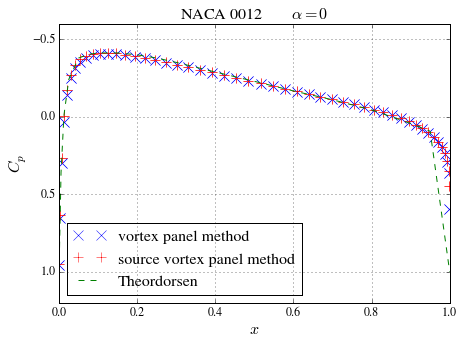

In [15]:
cp_theo = 1 - numpy.array([0, 0.64, 1.01, 1.241, 1.378, 1.402, 1.411, 1.411, 1.399, 1.378, 1.35, 1.288, 1.228, 1.166, 1.109, 1.044, 0.956, 0.906, 0])
x_theo = numpy.array([0, 0.5, 1.25, 2.5, 5.0, 7.5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 95, 100])/100
pyplot.figure(figsize=(7,5))
l1, = pyplot.plot(xc_0, cp_0, 'bx', markersize=10, label='vortex panel method')
l2, = pyplot.plot(xc_svpm, cp_svpm_0, 'r+', markersize=10, label='source vortex panel method')
l3, = pyplot.plot(x_theo, cp_theo, 'g--', markersize=10, label='Theordorsen')
pyplot.xlabel('$x$', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.legend(handles=[l1,l2,l3], loc=3, fontsize=16)
pyplot.grid('on')
pyplot.title(r'NACA 0012 $\quad$ $\alpha = 0$', fontsize=16)
pyplot.gca().invert_yaxis();

The panel method's result matches the Theordosen's method pretty well except for the trailing edge area (after 95% chord length). That is because the pressure coefficients we get are on control points rather than end points. The results from the two panel methods are very close, showing that we can use various types of sigularities for panel method.

Then we test NACA 0012 at $\alpha = 10$.

In [16]:
xc_10, cp_10, cl_10 = vortex_panel_method('NACA0012_N=100', 10.) 

Plot the $C_p$ distribution at $\alpha = 10$ and compare with source vortex panel method's solution.

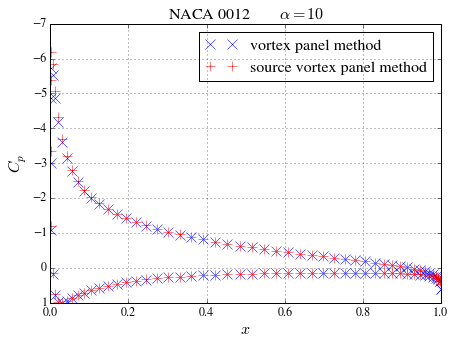

In [17]:
pyplot.figure(figsize=(7,5))
l1, = pyplot.plot(xc_10, cp_10, 'bx', markersize=10, label='vortex panel method')
l2, = pyplot.plot(xc_svpm, cp_svpm_10, 'r+', markersize=10, label='source vortex panel method')
pyplot.xlabel('$x$', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.legend(handles=[l1,l2], loc=1, fontsize=16)
pyplot.grid('on')
pyplot.title(r'NACA 0012 $\quad$ $\alpha = 10$', fontsize=16)
pyplot.gca().invert_yaxis();

Then we compare the lift coefficient.

In [18]:
print "angle of attack : 10 deg"
print "Cl using vortex panel method is %.3f." % cl_10
print "Cl using source vortex panel method is 1.209."

angle of attack : 10 deg
Cl using vortex panel method is 1.189.
Cl using source vortex panel method is 1.209.


The two results are very close to each other. The difference in lift comes from the inconsistency at the upper surface's leading edge, and the last few panels at the trailing edge. One reason for this might be the implementation of the Kutta condition. In the source vortex panel method, we set the tangential velocity at the center of the first and last panel to be the same. However, in the vortex panel method, when we set $\gamma_1 = \gamma_{N+1}$, we are directly enforcing that the flow does not go around the trailing edge.

### Vortex Panel Method + Method of Images

From [lesson 07](http://nbviewer.ipython.org/github/barbagroup/AeroPython/blob/master/lessons/07_Lesson07_methodOfImages.ipynb), we learn that we can "create" a wall by adding an image point source (with same source strength) or adding an image point vortex (with same vortex strength but an opposite sign) at a symmetrical position.

In the vortex panel method, we only have linear vortex distributions on each panel. Therefore, if we want to consider the wall's effect, we only need to create an image "airfoil" with the same vortex distribution but an opposite sign. And the Kutta condition does not need to be changed (Think about the way we enforce the Kutta condition here $\gamma_1 = \gamma_{N+1}$).

In contrast, if we use the source vortex panel method for ground effect, we also need to mirror the sources with the same sign, and what is more, we have to change the Kutta condition (the procedure is similar to a multi-airfoil configuration as [this assignment](http://nbviewer.ipython.org/github/barbagroup/AeroPython/blob/master/lessons/11_Lesson11_Assignment.ipynb)).

Let us start computing the ground effect by loading the airfoil NACA 0012 again.

In [19]:
x, y = numpy.loadtxt('resources/NACA0012_N=100', delimiter=' ', unpack=True)

In the method of image, we always want to set the ground (wall) on the x-axis, therefore, when the angle of attack is non-zero, we rotate the geometry instead and then we translate the airfoil according to the height $h$ (the leading edge's distance from the ground), finally we create the mirror.

In [20]:
h, alpha = 0.5, 10.0

In [21]:
x_rot = x*numpy.cos(alpha/180.*numpy.pi) + y*numpy.sin(alpha/180.*numpy.pi)
y_rot = -x*numpy.sin(alpha/180.*numpy.pi) + y*numpy.cos(alpha/180.*numpy.pi) + h
x, y = x_rot, y_rot
x_i, y_i = x_rot, -y_rot

Let us plot the NACA 0012 airfoils with $h = 0.5$ and $\alpha = 10.0$

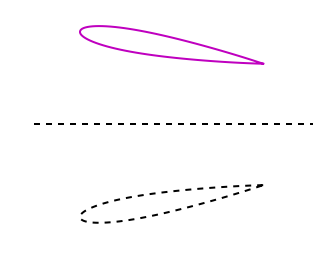

In [22]:
pyplot.figure(figsize=(5,4), frameon=False)
pyplot.plot(x,y, 'm-', linewidth=2)
pyplot.plot(x_i, y_i, 'k--', linewidth=2)
pyplot.axis('equal')
pyplot.axis('off')
pyplot.xlim(-0.5,1.5)
pyplot.axhline(0., color='k', linestyle='--', linewidth=2);

Calculate the geometry parameters of the main airfoil and image panels.

In [23]:
xc = 0.5*(x[1:] + x[:-1])    # x of panel's center
yc = 0.5*(y[1:] + y[:-1])    # y of panel's center
np = len(xc)    # number of panels
l = numpy.sqrt((x[1:]-x[:-1])**2 + (y[1:]-y[:-1])**2)    # panel's length
theta = numpy.arctan2(y[1:]-y[:-1],x[1:]-x[:-1])    # panel's angle with horizontal axis
theta_i = -theta    # image panel's angle with x-axis

Now the boundary condition on each control point can be written as:

$$
\sum_{j=1}^N \left( C_{n1_{m}}(i,j) \cdot \gamma'_j + C_{n2_{m}}(i,j) \cdot \gamma'_{j+1}\right) - \sum_{j=1}^N \left( C_{n1_{i}}(i,j) \cdot \gamma'_j + C_{n2_{m}}(i,j) \cdot \gamma'_{j+1}\right) = \sin(\theta_i - \alpha)
$$

The subscripts $m,i$ represent main airfoil and image airfoil respectively. The first part is the influence from a vortex on the main airfoil, while the second part is the contribution from a vortex on the image airfoil. The sign is "-" because image's vortex has opposite sign.

Based on the `evaluate_coefficient` function, we can easily create a new function `evaluate_coefficient_image` to calculate the coefficient from the image airfoil. The only modification is that we no longer need to worry about the singular case when $i=j$.

In [24]:
def evaluate_coefficient_image(x_i, y_i, xc, yc, theta_i, l):
    """Given the end points' coordinates (x,y), angles(theta), panel length (l) of target panels, evaluate their contributions to source panels with control points (xc, yc), and return the panel-panel coefficient matrix in normal and tangential direction, and for the left end and right end respectively.
    
    Parameters:
    ----------
    x_i, y_i: (array of float)
          x,y coordinates of image panels' end points
    xc, yc: (array of float)
            x,y coordinates of control points on main airfoil panels
    theta_i: (array of float)
            array of angles between x-axis and image panels
    l: (array of float)
        array of image panels' length
        
    Returns:
    -------
    cn1_i: (array of float)
           the source image panel's left end vortex's contribution on target panel in normal direction
    cn2_i: (array of float)
           the source image panel's right end vortex's contribution on target panel in normal direction     
    ct1_i: (array of float)
           the source image panel's left end vortex's contribution on target panel in tangential direction
    ct2_i: (array of float)
           the source image panel's right end vortex's contribution on target panel in tangential direction
    """
    np = len(xc)
    cn1_i = numpy.zeros((np,np), dtype=float)
    cn2_i = numpy.zeros((np,np), dtype=float)
    ct1_i = numpy.zeros((np,np), dtype=float)
    ct2_i = numpy.zeros((np,np), dtype=float)
    for i in range(np):
        for j in range(np):
            A = -(xc[i]-x_i[j])*numpy.cos(theta_i[j])-(yc[i]-y_i[j])*numpy.sin(theta_i[j])
            B = (xc[i]-x_i[j])**2+(yc[i]-y_i[j])**2
            C = numpy.sin(theta[i]-theta_i[j])
            D = numpy.cos(theta[i]-theta_i[j])
            E = (xc[i]-x_i[j])*numpy.sin(theta_i[j])-(yc[i]-y_i[j])*numpy.cos(theta_i[j])
            F = numpy.log(1+(l[j]**2+2*A*l[j])/B)
            G = numpy.arctan2((E*l[j]),(B+A*l[j]))
            P = (xc[i]-x_i[j])*numpy.sin(theta[i]-2*theta_i[j])+(yc[i]-y_i[j])*numpy.cos(theta[i]-2*theta_i[j])
            Q = (xc[i]-x_i[j])*numpy.cos(theta[i]-2*theta_i[j])-(yc[i]-y_i[j])*numpy.sin(theta[i]-2*theta_i[j])
            cn2_i[i,j]=D+0.5*Q*F/l[j]-(A*C+D*E)*G/l[j]
            cn1_i[i,j]=0.5*D*F+C*G-cn2_i[i,j]
            ct2_i[i,j]=C+0.5*P*F/l[j]+(A*D-C*E)*G/l[j]
            ct1_i[i,j]=0.5*C*F-D*G-ct2_i[i,j]
    return cn1_i, cn2_i, ct1_i, ct2_i

Therefore, our total coefficient matrix $C_{n1}$ now is:
$$
C_{n1} = C_{n1_m} - C_{n1_i}
$$
the equations are similar for $C_{n2}$, $C_{t1}$, $C_{t2}$ (Think about where the minus sign comes from). 

Then we use the same method to build A, solve the linear system, and evaluate the tangential velocity and presure coefficient at the control points.

Keep in mind that when we rotate the coordinates of the airfoil, we already take the angle of attack $\alpha$ into consideration ($\theta$ of a panel reflects its angle between panel and freestream), so when we calculate the RHS, tangential velocity and total lift, we use $\theta$ instead of $(\theta-\alpha)$.

Now we wrap the code into `ground effect`, get ready for some test.

In [25]:
def ground_effect(filename, alpha, h):
    """Given the filename of panel coordinates file, and the angle of attack, and the height of the leading edge above the ground, return the control points, its pressure coefficient and total lift.
    
    Parameters:
    ----------
    filename: (string)
              Panel's coordinates input file
    alpha: (float)
            angle of attack in degree
    h: (float)
        the height of the leading edge above the ground
    
    Returns:
    -------
    xc: (array of float)
        array of control points' x coordinates
    cp: (array of float)
        array of pressure coefficient at the control points
    cl: (float)
        the lift coefficient of the airfoil under ground effect
           
    """
    # load airfoil data
    x, y = numpy.loadtxt('resources/'+filename, delimiter=' ', unpack=True)
    
    # rotate the coordinates
    x_rot = x*numpy.cos(alpha/180.*numpy.pi) + y*numpy.sin(alpha/180.*numpy.pi)
    y_rot = -x*numpy.sin(alpha/180.*numpy.pi) + y*numpy.cos(alpha/180.*numpy.pi) + h
    x, y = x_rot, y_rot
    x_i, y_i = x_rot, -y_rot
    
    # calculate the geometry parameters of panels
    xc = 0.5*(x[1:] + x[:-1])    # x of panel's center
    yc = 0.5*(y[1:] + y[:-1])    # y of panel's center
    np = len(xc)    # number of panels
    l = numpy.sqrt((x[1:]-x[:-1])**2 + (y[1:]-y[:-1])**2)    # panel's length
    theta = numpy.arctan2(y[1:]-y[:-1],x[1:]-x[:-1])    # panel's angle with horizontal axis
    theta_i = -theta
    
    # evaluate the panel-to-panel coefficient
    cn1_m, cn2_m, ct1_m, ct2_m = evaluate_coefficient(x, y, xc, yc, theta, l)
    cn1_i, cn2_i, ct1_i, ct2_i = evaluate_coefficient_image(x_i, y_i, xc, yc, theta_i, l)
    cn1, cn2, ct1, ct2 = cn1_m-cn1_i, cn2_m-cn2_i, ct1_m-ct1_i, ct2_m-ct2_i
    
    # evaluate the coefficient matrix A (related to gammas)
    an, at = build_A(cn1, cn2, ct1, ct2)
    
    # calculate the rhs (alpha is included in panel's geometry)
    b = numpy.sin(theta)    # freestream's contribution
    b = numpy.append(b, 0.)    # add kutta condition
    
    # solve the linear system
    gamma = numpy.linalg.solve(an, b)
    
    # evaluate the tangential velocity and pressure coefficient at control points
    vt = numpy.dot(at, gamma) + numpy.cos(theta)
    cp = 1 - vt**2
    
    # evaluate the lift
    cl = -numpy.dot(cp, l*numpy.cos(theta))
    
    return xc, cp, cl

### Ground Effect on an Airfoil

In order to observe how ground influences the airfoil , we run our code at $\alpha = 10$, $h$ ranging from $0.2$ to $1.0$, and compare with the performance of a NACA 0012 airfoil under no ground effect. Since we are always using a unit-chord-length airfoil $(c=1)$, the height $h$ is can also be written as $h/c$.

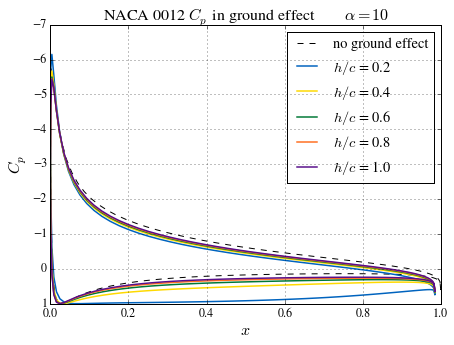

In [26]:
# run ground effect in a series of different height
alpha = 10.
n_set = 5
h_set = numpy.linspace(0.2, 1.0, n_set)
xc_set, cp_set, cl_set = [None]*n_set, [None]*n_set, [None]*n_set
for i,h in enumerate(h_set):
    xc_set[i], cp_set[i], cl_set[i] = ground_effect('NACA0012_N=100', alpha, h)

rcParams['font.size'] = 12
colors = ["#0063be","#fed900","#007836","#ff6f20","#580f8b"]
# plot the cp distribution and compare with source vortex panel solution
pyplot.figure(figsize=(7,5))
pyplot.plot(xc_10, cp_10, 'k--', linewidth=1, label='no ground effect')
for i,h in enumerate(h_set):
    pyplot.plot(xc_set[i], cp_set[i], color=colors[i], linewidth=1.5, label='$h/c$ = '+str(h))
pyplot.xlabel('$x$', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.legend(loc=1)
pyplot.grid('on')
pyplot.title(r'NACA 0012 $C_p$ in ground effect $\quad$ $\alpha = 10$', fontsize=16)
pyplot.gca().invert_yaxis();

The dashed line shows the result using the vortex panel method we just created, and the other color lines represent the $C_p$ of the main airfoil at different ground clearance. We can see from the figure that, when the airfoil is coming closer and closer to the ground, the $C_p$ on the upper (suction) surface stays almost the same, while the $C_p$ on the lower (pressure) surface increases gradually. This high pressure is what gives the pilot the feeling of an "air cushion" underneath.

Now let us tweak the angle of attack $\alpha$ to know more about ground effect. In the following test, a series of $\alpha$ values are used, and for each $\alpha$, we test the airfoil at different heights $h/c$. Then we plot $C_l$ vs. $h/c$ for each $\alpha$.

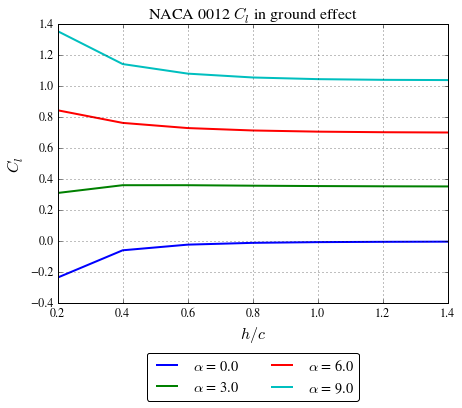

In [27]:
alpha_set = numpy.linspace(0., 9., 4)
h_set = numpy.linspace(0.2, 1.4, 7)
cl_set = numpy.zeros(len(h_set), dtype=float)
pyplot.figure(figsize=(7,5))
for i, alpha in enumerate(alpha_set):
    for j, h in enumerate(h_set):
        cl_set[j] = ground_effect('NACA0012_N=100', alpha, h)[-1]    
    pyplot.plot(h_set, cl_set, label=r'$\alpha$ = '+str(alpha), linewidth=2)
pyplot.xlabel('$h/c$', fontsize=16)
pyplot.ylabel('$C_l$', fontsize=16)
pyplot.title(r'NACA 0012 $C_l$ in ground effect', fontsize=16)
pyplot.grid('on')
pyplot.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, ncol=2)
pyplot.show();

As the ground clearance goes below $0.4$ (when the airfoil is extremely close to the ground surface), the lift coefficient $C_l$ changes rapidly. From the figure, for cases $\alpha = 6$ and $\alpha = 9$, the $C_l$ increases sharply when $h/c<0.4$. The higher angle of attack, the greater slope in that region. However, when it comes to a small angle of attack $\alpha = 0$ and $\alpha=3$, there is a negative lift when $h/c < 0.4$. The trends diverge, so what happens?

Let us test the airfoil with $h/c=0.2$ and $\alpha=0$ and $\alpha=10$ respectively.

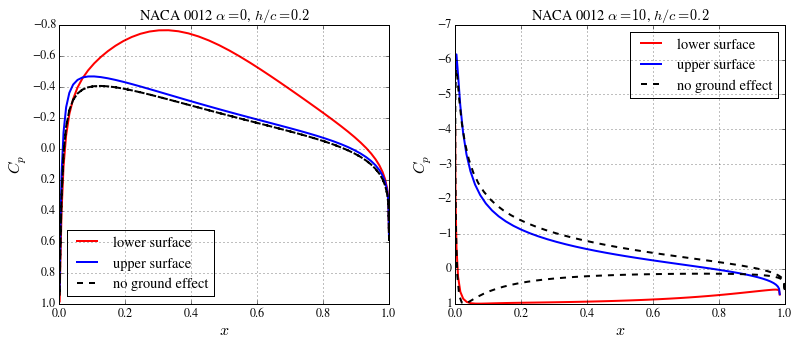

In [28]:
x_1, cp_1, cl_1 = ground_effect('NACA0012_N=100', 0.0, 0.2)
x_2, cp_2, cl_2 = ground_effect('NACA0012_N=100', 10.0, 0.2)
pyplot.figure(figsize=(13,5))
pyplot.subplot(1,2,1)
pyplot.plot(x_1[:np/2], cp_1[:np/2], 'r-', linewidth=2, label='lower surface')
pyplot.plot(x_1[np/2:], cp_1[np/2:], 'b-', linewidth=2, label='upper surface')
pyplot.plot(xc_0, cp_0, 'k--', linewidth=2, label='no ground effect')
pyplot.legend(loc='best')
pyplot.grid('on')
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.xlabel('$x$', fontsize=16)
pyplot.title(r'NACA 0012 $\alpha = 0$, $h/c = 0.2$')
pyplot.gca().invert_yaxis()
pyplot.subplot(1,2,2)
pyplot.plot(x_2[:np/2], cp_2[:np/2], 'r-', linewidth=2, label='lower surface')
pyplot.plot(x_2[np/2:], cp_2[np/2:], 'b-', linewidth=2, label='upper surface')
pyplot.plot(xc_10, cp_10, 'k--', linewidth=2, label='no ground effect')
pyplot.legend(loc='best')
pyplot.grid('on')
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.xlabel('$x$', fontsize=16)
pyplot.title(r'NACA 0012 $\alpha = 10$, $h/c = 0.2$')
pyplot.gca().invert_yaxis();

We can see in either case, the upper surface's $c_p$ does not change a lot compared with result without ground effect, however, the performance of the lower surface at different $\alpha$ diverges for very small clearances $(h/c)$. For a larger angle of attack, $\alpha = 10$ in this case, the flow nearly stagnates under the lower surface, creating a huge amount of lift, and some paper names this effect as "ram pressure". However, for a symmetrical airfoil NACA 0012 at zero angle of attack, the lower surface and the ground forms a "convergent-divergent" passage ([de Laval nozzle](http://en.wikipedia.org/wiki/De_Laval_nozzle)). Due to the thickness of the airfoil, after the leading edge, the cross-section area of airflow is shrinking, so the air under the lower surface speeds up, giving rise to a low pressure region at the lower surface.

For any airfoil in ground effect with a very small ground clearance ($h/c < 0.4$ in this case), these two effects ("ram pressure" and "convergent-divergent passage") coexist. When $\alpha$ is greater, the former dominates, showing an increasing of $C_l$; while if $\alpha$ is small, the latter dominates, creating a negative lift.

### And more ... on NACA 4412

Let us test on a cambered airfoil NACA 4412 to see whether we can find a similar trend.

In [29]:
x, y = numpy.loadtxt('resources/NACA4412_N=100', delimiter=' ', unpack=True)

In [30]:
h, alpha = 0.5, 0.0
x_rot = x*numpy.cos(alpha/180.*numpy.pi) + y*numpy.sin(alpha/180.*numpy.pi)
y_rot = -x*numpy.sin(alpha/180.*numpy.pi) + y*numpy.cos(alpha/180.*numpy.pi) + h
x, y = x_rot, y_rot
x_i, y_i = x_rot, -y_rot

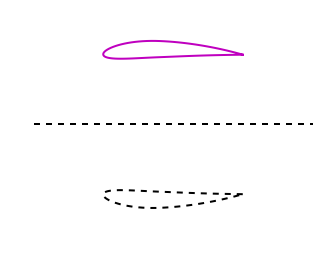

In [31]:
pyplot.figure(figsize=(5,4), frameon=False)
pyplot.plot(x,y, 'm-', linewidth=2)
pyplot.plot(x_i, y_i, 'k--', linewidth=2)
pyplot.axis('equal')
pyplot.axis('off')
pyplot.xlim(-0.5,1.5)
pyplot.axhline(0., color='k', linestyle='--', linewidth=2);

We do a similar case study on NACA 4412. And compare with the result in [ref 4].

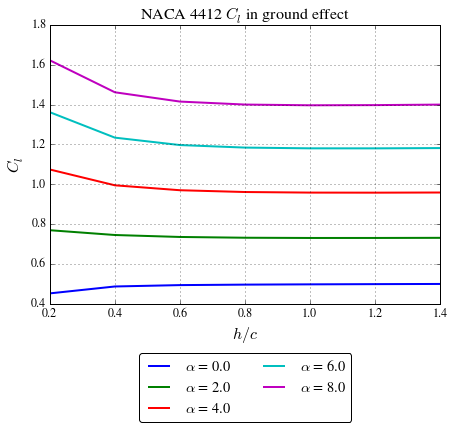

In [32]:
alpha_set = numpy.linspace(0., 8., 5)
h_set = numpy.linspace(0.2, 1.4, 7)
cl_set = numpy.zeros(len(h_set), dtype=float)
pyplot.figure(figsize=(7,5))
for i, alpha in enumerate(alpha_set):
    for j, h in enumerate(h_set):
        cl_set[j] = ground_effect('NACA4412_N=100', alpha, h)[-1]    
    pyplot.plot(h_set, cl_set, label=r'$\alpha$ = '+str(alpha), linewidth=2)
pyplot.xlabel('$h/c$', fontsize=16)
pyplot.ylabel('$C_l$', fontsize=16)
pyplot.title('NACA 4412 $C_l$ in ground effect', fontsize=16)
pyplot.grid('on')
pyplot.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, ncol=2);

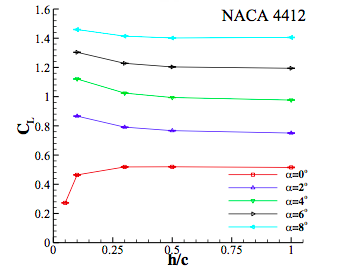

In [33]:
Image(filename='resources/NACA4412_cl.png')

Image credit: Fig.15, Implementation of a 2D Panel Method for Potential Flow Past Multi-Element Airfoil Configurations, by Diogo Chaves

Chaves's paper uses source vortex panel method to calculate the ground effect (but does not panel number he used). The trends match well: when $\alpha > 2$, "ram pressure" dominates, when $\alpha = 0$, "convergent-divergent effect" dominates.

### Ground Effect for Racecars

We just discussed that at a small angle of attack, when the airfoil is very close to the ground, there will be a lift decrease or even negative lift due to the shrinking passage cross section area. That is not good news for aircraft, but can we benefit from that?

Of course, the racecar designers are saying 'yes'. 

[Lotus 79](http://en.wikipedia.org/wiki/Lotus_79) was the first Formula One car designed to take advantage of ground effect. It was designed in late 1977, and the Team Lotus won the Formula One championship in the following year. Due to its success and popularity, Lotus is still being used for some tutorials of the racing simulation today.

In order to enhance the grip and make faster turns, racecars need a great amount of downforce. From what we discovered just now, we know that when both $h/c$ and $\alpha$ are very small, the lower surface has a low pressure. In order to create a greater downforce, we also want a higher pressure on the upper surface, and the easiest way is to use a flat surface since any camber on the upper surface will cause air to accelerate. That is probably how the engineers developed their ideas at that time. Below is a sketch of the Lotus 79.

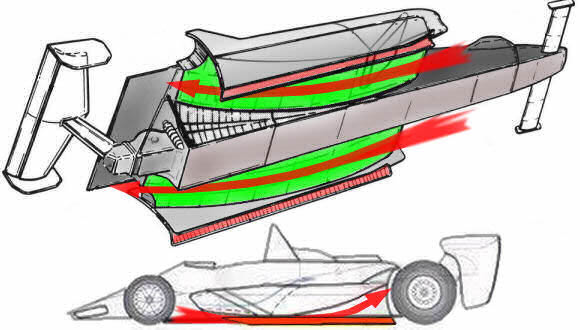

In [34]:
Image(filename='resources/lotus79.jpg')

Image credit: Lotus 79 http://www.formula1-dictionary.net/Images/ground_effect_lotus79b.jpg

In this notebook, we will use an inverted NACA 4412 airfoil at $\alpha = -4$ to simulate the Lotus 79 underbody.

In [35]:
x, y = numpy.loadtxt('resources/NACA4412_inv_N=100', delimiter=' ', unpack=True)

In [36]:
h, alpha = 0.5, -4.0

In [37]:
x_rot = x*numpy.cos(alpha/180.*numpy.pi) + y*numpy.sin(alpha/180.*numpy.pi)
y_rot = -x*numpy.sin(alpha/180.*numpy.pi) + y*numpy.cos(alpha/180.*numpy.pi) + h
x, y = x_rot, y_rot
x_i, y_i = x_rot, -y_rot

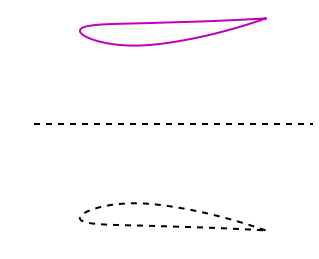

In [38]:
pyplot.figure(figsize=(5,4), frameon=False)
pyplot.plot(x,y, 'm-', linewidth=2)
pyplot.plot(x_i, y_i, 'k--', linewidth=2)
pyplot.axis('equal')
pyplot.axis('off')
pyplot.xlim(-0.5,1.5)
pyplot.axhline(0., color='k', linestyle='--', linewidth=2);

Plot $C_p$ at different ground clearance $h/c$.

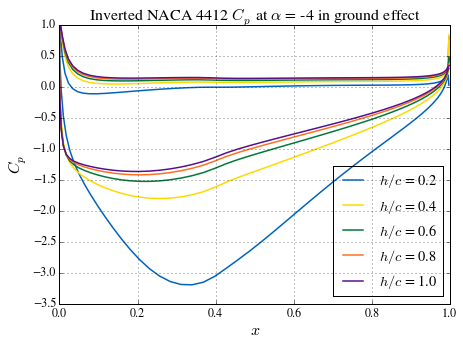

In [39]:
alpha = -4.0
n_set = 5
h_set = numpy.linspace(0.2, 1.0, n_set)
xc_set, cp_set, cl_set = [None]*n_set, [None]*n_set, [None]*n_set
for i,h in enumerate(h_set):
    xc_set[i], cp_set[i], cl_set[i] = ground_effect('NACA4412_inv_N=100', alpha, h)

rcParams['font.size'] = 12
colors = ["#0063be","#fed900","#007836","#ff6f20","#580f8b"]
# plot the cp distribution and compare with source vortex panel solution
pyplot.figure(figsize=(7,5))
for i,h in enumerate(h_set):
    pyplot.plot(xc_set[i], cp_set[i], color=colors[i], linewidth=1.5, label='$h/c$ = '+str(h))
pyplot.xlabel('$x$', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.legend(loc=4)
pyplot.grid('on')
pyplot.title(r'Inverted NACA 4412 $C_p$ at $\alpha$ = -4 in ground effect', fontsize=16)
pyplot.xlim(0.0, 1.0);

And plot the lift coefficient $C_l$ vs ground clearance $h/c$.

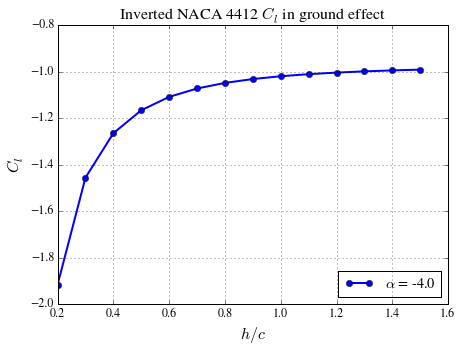

In [40]:
alpha = -4.0
h_set = numpy.linspace(0.2, 1.5, 14)
cl_set = numpy.zeros(len(h_set), dtype=float)
pyplot.figure(figsize=(7,5))
for i, h in enumerate(h_set):
    cl_set[i] = ground_effect('NACA4412_inv_N=100', alpha, h)[-1]    
pyplot.plot(h_set, cl_set, label=r'$\alpha$ = '+str(alpha), linewidth=2, marker='o')
pyplot.xlabel('$h/c$', fontsize=16)
pyplot.ylabel('$C_l$', fontsize=16)
pyplot.title(r'Inverted NACA 4412 $C_l$ in ground effect', fontsize=16)
pyplot.grid('on')
pyplot.legend(loc=4);

When $h/c = 0.2$, the lower surface has a low pressure region. As a result, the total downforce nearly doubles the downforce without ground effect ($h/c>1.4$).

### Review & Conclusion

First, we created a vortex panel method code, and based on that we can get an accurate solution compared with the theorectical result and the result from the source vortex panel method. Then we used the method of images to duplicate a symmetrical image airfoil below the ground, and extend our code to consider ground effect. We tested the NACA 0012 and NACA 4412 airfoil with the code, and compared the $C_p$ trend with the result from Chaves's paper.

When we are looking at the $C_l$ vs $h/c$ at different angles of attack, in some small ground clearance region $h/c < 0.2$, the $C_l$ shows a greater slope. But for different angle of attack, their trends diverge. In a higher angle of attack case, the air flow leaves the trailing edge of the airfoil and rams to the ground. This effect is similar to a flap's effect on the main airfoil (we discussed in the last class with the multi-element airfoil assignment). The ground effect results in a high pressure region on the lower surface, therefore, leading to a sharp increase in $C_l$. However, when it comes to a small angle of attack ($\alpha$ is close to zero), the airfoil is quite parallel to the ground. The lower surface and the ground form a "convergent-divergent" passage. Due to the shrinking cross-section area, the airflow accelerates in the region, creating a low pressure area on the lower surface. For a symmetrical airfoil at zero angle of attack, this might even generate a negative lift. Therefore, for a given $\alpha$ and $h/c$, these two effects coexist. When $\alpha$ is relatively greater, the "ramming" effect domainates the other, creating a increasing lift; while when $\alpha$ is closer to zero, the "convergent-divergent" passage effect dominates the other, showing a decreasing lift.

In order to make full use of the effect of decreased lift, we can design an airfoil using the second effect to generate more downforce. We select Lotus 79's underbody as our model, and we use an inverted NACA 4412 at $\alpha = -4$ to approximate its shape. We found that when the airfoil is at a small ground clearance $h/c < 0.2$, the $C_l$ nearly doubles that without ground effect.

This notebook only considers 2d ground effect in potential flow, still there are lots of 3d effects involved with wingtip vortices, helicopter's ground effect and viscous effect in racecar design.  

### Dig Deeper

In addition to $C_p$ and $C_l$, the pitching moment of an airfoil is also very important. Based on this code, you can figure out how much is an airfoil's pitching moment with respect to the leading edge, and where is the center of pressure. These performance aspects matter a lot when you want to manuever a flight. And then adding the ground effect module, we can observe how the ground effect changes the pitching moment and center of pressure. Think about and discuss its effect in a real landing situation.

### Reference

1. Kuethe, Arnold M., and Chuen-Yen Chow. Foundations of Aerodynamics: Bases of Aerodynamics Design. Fifth Edition. Wiley, 1997
2. Katz, Joseph, and Allen Plotkin. Low Speed Aerodynamics. Cambridge, UK: Cambridge UP, 2001
3. Ahmed, Mohammed R., T. Takasaki, and Y. Kohama. "Aerodynamics of a NACA4412 airfoil in ground effect." AIAA journal 45.1 (2007): 37-47.
4. Chaves, Diogo. Implementation of a 2D Panel Method for Potential Flow Past Multi-Element Airfoil Configurations, Technical University of Lisbon, 2012
5. Ahmed, Mohammed R., and S. D. Sharma. "An investigation on the aerodynamics of a symmetrical airfoil in ground effect." Experimental Thermal and Fluid Science 29.6 (2005): 633-647.
6. "Lotus 79". (n.d.). In Wikipedia. Retrieved May 6, 2015, from http://en.wikipedia.org/wiki/Lotus_79

In [41]:
%%javascript
IPython.load_extensions('IPython-notebook-extensions-3.x/usability/codefolding/main');

<IPython.core.display.Javascript object>

In [42]:
# css file comes from AeroPython
from IPython.core.display import HTML
def css_styling():
    styles = open('./resources/custom.css', 'r').read()
    return HTML(styles)
css_styling()